[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ellisalicante/GraphRewiring-Tutorial/blob/main/2-Lovasz-Bound-and-CT.ipynb)

# The Lovász Bound
Francisco Escolano, ELLIS Alicante UNIT

Adrián Arnaiz Rodríguez, ELLIS Alicante UNIT

Ahmed Begga, University of Valencia

***Tutorial on Graph Rewiring: From Theory to Applications in Fairness***

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ellisalicante/GraphRewiring-Tutorial/blob/main/2-Lovasz-Bound-and-CT.ipynb)

In [ ]:
# Interesting color use: https://github.com/binodbhttr/mycolorpy/blob/master/usage_example.ipynb
COLLAB_ENV = False
if COLLAB_ENV:
    !pip install 'scipy>=1.8'
    !pip install mycolorpy

: 

## Lovász Bound and Fiedler Vector

In [ ]:
import networkx as nx
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as matplotlib
import matplotlib.cm as cm
from mycolorpy import colorlist as mcp

# Plot the k-th Laplacian Eigenvalue on the Graph
def plot_eigenvector_over_graph(G,evecs,k, cmap="seismic", pos=None, node_size=40):
  # Extract eigenvector from the evecs matrix and transform into dim (n,)
  u = np.real(evecs[:,k])
  u = np.transpose(u)
  u2 = np.squeeze(u)
  v = np.zeros(u2.shape[1])
  for i in range(u2.shape[1]):
    # Add 100 to overcome negative values
    v[i] = u2[0,i] + 100
    
  # Create the color map 
  vColor =mcp.gen_color_normalized(cmap,data_arr=v)
  if pos == None: 
    pos = nx.spring_layout(G,seed=63)  # Seed layout for reproducibility
  else: 
    pos = pos
  # Draw the graph
  nx.draw(G, pos, node_color=vColor, node_size=node_size, width=0.2, cmap=plt.cm.Blues)
  plt.show()
  return pos

# Find eigen values and vectors of a Laplacian L
def find_eigen(L): 
  # Finding eigen values and eigen vectors
  e, evecs = np.linalg.eig(L.todense())
  e.shape, evecs.shape
  # Sort them (both e's and evecs's) ascending
  idx =e.argsort()
  e = e[idx]
  evecs = evecs[:,idx]
  return e, evecs


**Create synthetic graphs**

In [ ]:
# Start to work on the graphs 
sizes = [100, 100]
# SBM with small gap
probsG = [[0.8, 0.01], [0.01, 0.8]]
G = nx.stochastic_block_model(sizes, probsG, seed=0)

# SBM with larger gap
probsH = [[0.8, 0.5], [0.5, 0.8]]
H = nx.stochastic_block_model(sizes, probsH, seed=0)

#L = nx.normalized_laplacian_matrix(G)
AG = nx.adjacency_matrix(G)
LG = nx.normalized_laplacian_matrix(G)
eG, evecsG = find_eigen(LG)

AH = nx.adjacency_matrix(H)
LH = nx.normalized_laplacian_matrix(H)
eH, evecsH = find_eigen(LH)

**We plot the graph with the values of Fielder vector as nodes' color**

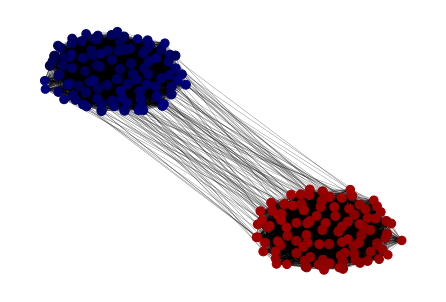

Bottleneck of G is 0.027295784924703657


In [ ]:
# Plot Fiedler's vector over graph G (small Gap)
degreeG = list(dict(G.degree).values())
posG = plot_eigenvector_over_graph(G,evecsG,1, node_size=degreeG)
print("Bottleneck of G is", eG[1])

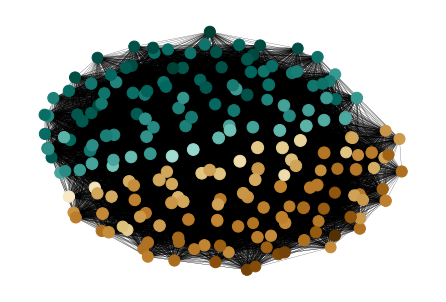

Bottleneck of H is 0.7588701310820082


In [ ]:
# Plot Fiedler's vector over graph H (Larger gap)
degreeH = list(dict(H.degree).values())
posH = plot_eigenvector_over_graph(H,evecsH,1, cmap="BrBG", node_size=degreeH)
print("Bottleneck of H is", eH[1])

In [ ]:
# Readouts from the Fiedler's vector
FiedlerG = evecsG[:,1]
FiedlerH = evecsH[:,1] 
print(FiedlerG.shape)
ReadoutG = [sum(FiedlerG[0:99]).item(), sum(FiedlerG[100:199]).item()]
print(ReadoutG)
ReadoutH = [sum(FiedlerH[100:199]).item(), sum(FiedlerH[0:99]).item()]
print(ReadoutH)

(200, 1)
[7.008579244888816, -6.981922422704969]
[6.814791650920959, -6.836648418167607]


**Histogram of Fielder vector values**

In [ ]:
# Using seaborn
import pandas as pd

FGVis =  np.squeeze(np.array(FiedlerG.copy()))
FHVis =  np.squeeze(np.array(FiedlerH.copy()))

df_data_G = pd.DataFrame(list(zip(FGVis,['G']*200,[0]*100+[1]*100)), columns=['Fiedler', 'Graph', 'Class'])
df_data_H = pd.DataFrame(list(zip(FHVis,['H']*200,[0]*100+[1]*100)), columns=['Fiedler', 'Graph', 'Class'])
df_data = pd.concat([df_data_G, df_data_H]).reset_index()

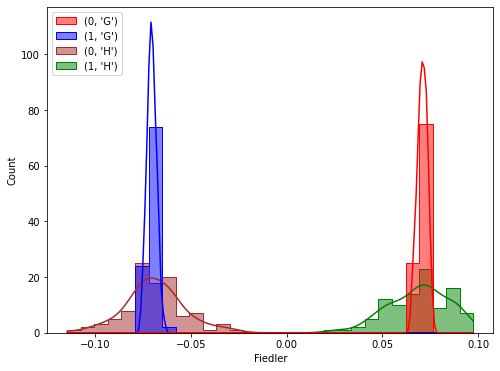

In [ ]:
style = {'bins':30, 'kde':True, 'element':"step"}
plt.figure(figsize=(8,6))
sns.histplot(data=df_data, x='Fiedler', hue=df_data[['Class', 'Graph']].apply(tuple, axis=1), alpha=0.5, palette=["r", "b", "brown", "g"], **style)
plt.show()

### Exercise: change p of one class from 0.8 to 0.6 -> overlap

In [ ]:
# Exercise: change p of one class from 0.8 to 0.6 -> overlap 

## Commute Times embbedding and bottleneck

In [ ]:
# Commute Times Embedding
from scipy.linalg import fractional_matrix_power
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from sklearn.manifold import TSNE

def visualize(z, color, size=10, save=False, title='img', plot_type='kde'):
    plt.figure(figsize=(5,5))
    if plot_type=='kde':
      sns.kdeplot(z[:, 0], z[:, 1], s=size, c=color, cmap="seismic")
    elif plot_type=='scatter':
      sns.scatterplot(z[:, 0], z[:, 1], s=size, c=color, cmap="seismic")
    else:
      raise NotImplementedError("Wrong plot type")
    #plt.colorbar()
    plt.xticks([], [])
    plt.yticks([], [])
    if save:
        plt.savefig(title+'.pdf') 
    plt.show()

def graph_vol(G):
    A = nx.adjacency_matrix(G)
    D = A.sum(axis=1)
    D = D.squeeze()
    d = np.zeros(G.number_of_nodes())
    for i in range(G.number_of_nodes()):
        d[i] = D[0,i]
    vol = d.sum()
    return vol

def commute_times_embedding(G,e, evecs):
    n = G.number_of_nodes()
    vol = graph_vol(G)
    A = nx.adjacency_matrix(G)
    D = A.sum(axis=1)
    Phi = evecs
    Lambda = np.diag(e)
    Lambda = fractional_matrix_power(Lambda, -0.5)
    Lambda[0,0] = 0
    CTE = np.sqrt(vol)*np.matmul(Lambda,np.transpose(Phi))
    # Embedding is in the columns
    return CTE



/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 's', 'c'
  cset = contour_func(


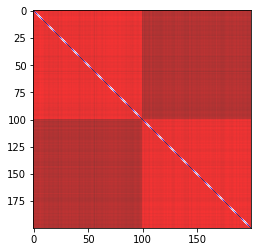

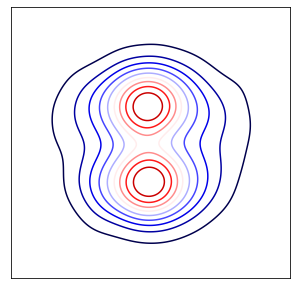

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


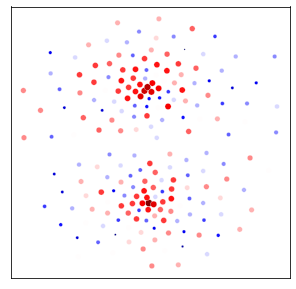

In [ ]:
# Use now the unnormalized Laplacian for simplicity: 
LG = nx.laplacian_matrix(G)
eG, evecsG = find_eigen(LG)

# Distance Matrix
CTE = np.real(commute_times_embedding(G,eG, evecsG))
CT = pdist(np.transpose(CTE), 'euclidean')
CT = squareform(CT)
plt.imshow(CT, alpha=0.8, cmap="seismic")

# TSNE Visualization
spectral_CTE_G = np.real(commute_times_embedding(G,eG, evecsG).T) #CUIDADO, yo tuve que hacer la transpuesta para que cada fila fuese un nodo en vez de columna
spec_cte_2d = TSNE(n_components=2, learning_rate='auto',
               init='random', perplexity=6, early_exaggeration=100, random_state=200).fit_transform(spectral_CTE_G.real) #cambiar perplexity y early_exageration para que salga bien el embedding
degree = np.diag(LG.todense())# La manera que quieras de calcular el grado de los nodos para el color o el tamaño
visualize(spec_cte_2d , color = degree)
visualize(spec_cte_2d , color = degree, size= (degree-degree.min())/(degree.max()-degree.min())*50, plot_type='scatter')

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 's', 'c'
  cset = contour_func(


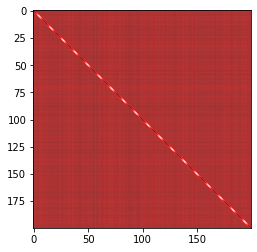

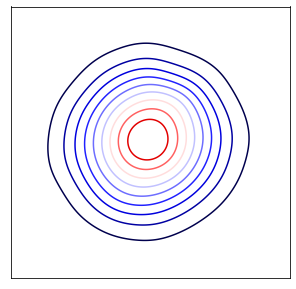

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


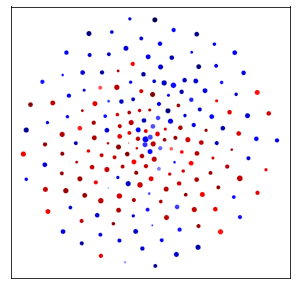

In [ ]:
# Use now the unnormalized Laplacian for simplicity: 
LH = nx.laplacian_matrix(H)
eH, evecsH = find_eigen(LH)

# Distance Matrix
CTE = np.real(commute_times_embedding(H,eH, evecsH))
CT = pdist(np.transpose(CTE), 'euclidean')
CT = squareform(CT)
plt.imshow(CT, alpha=0.8, cmap="seismic")

# TSNE Visualization
spectral_CTE_H = np.real(commute_times_embedding(H,eH, evecsH).T) #CUIDADO, yo tuve que hacer la transpuesta para que cada fila fuese un nodo en vez de columna
spec_cte_2d = TSNE(n_components=2, learning_rate='auto',
               init='random', perplexity=6, early_exaggeration=100, random_state=200).fit_transform(spectral_CTE_H.real) #cambiar perplexity y early_exageration para que salga bien el embedding
degree = np.diag(LG.todense())# La manera que quieras de calcular el grado de los nodos para el color o el tamaño
visualize(spec_cte_2d , color = degree, size= degree/2)
visualize(spec_cte_2d , color = FiedlerH, size= (degree-degree.min())/(degree.max()-degree.min())*40, plot_type='scatter')

**Plot CT Distance**

In [ ]:
import torch 

# get spectral ct dist
spectral_CT_dist_G = pdist(spectral_CTE_G.real, 'euclidean')
spectral_CT_dist_G = torch.Tensor(squareform(spectral_CT_dist_G))

#get vectorized UPPER TRANGULAR ct dist
idx = torch.Tensor(spectral_CT_dist_G).triu().nonzero().T
spec_CT_dist_triu_G = spectral_CT_dist_G[idx[0], idx[1]]
spec_CT_dist_triu_G = spec_CT_dist_triu_G / spec_CT_dist_triu_G.sum()


#plt.hist(spec_CT_dist_triu_G.numpy(), bins=10)

In [ ]:
import torch 

# get spectral ct dist
spectral_CT_dist_H = pdist(spectral_CTE_H.real, 'euclidean')
spectral_CT_dist_H = torch.Tensor(squareform(spectral_CT_dist_H))

#get vectorized UPPER TRANGULAR ct dist
idx = torch.Tensor(spectral_CT_dist_H).triu().nonzero().T
spec_CT_dist_triu_H = spectral_CT_dist_H[idx[0], idx[1]]
spec_CT_dist_triu_H = spec_CT_dist_triu_H / spec_CT_dist_triu_H.sum()
print("spec", spec_CT_dist_triu_H, len(spec_CT_dist_triu_H))

#plt.hist(spec_CT_dist_triu_G.numpy(), bins=10)

spec tensor([5.0264e-05, 5.0070e-05, 5.0839e-05,  ..., 5.0536e-05, 5.0646e-05,
        5.0841e-05]) 19900


In [ ]:
# Using seaborn
import pandas as pd

SpecGVis =  np.squeeze(np.array(spec_CT_dist_triu_G.clone()))
SpecHVis =  np.squeeze(np.array(spec_CT_dist_triu_H.clone()))

df_prob_G = pd.DataFrame(list(zip(SpecGVis,['G']*len(spec_CT_dist_triu_G))), columns=['EdgeP', 'Graph'])
df_prob_H = pd.DataFrame(list(zip(SpecHVis,['H']*len(spec_CT_dist_triu_G))), columns=['EdgeP', 'Graph'])
df_prob = pd.concat([df_prob_G, df_prob_H]).reset_index()

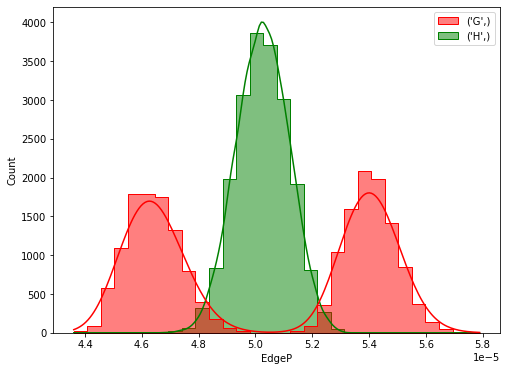

In [ ]:
style = {'bins':30, 'kde':True, 'element':"step"}
plt.figure(figsize=(8,6))
sns.histplot(data=df_prob, x='EdgeP', hue=df_prob[['Graph']].apply(tuple, axis=1), alpha=0.5, palette=["r", "g"], **style)
plt.show()

In [ ]:
df_prob

,index,EdgeP,Graph
0,0,0.000048,G
1,1,0.000048,G
2,2,0.000048,G
3,3,0.000048,G
4,4,0.000048,G
...,...,...,...
39795,19895,0.000051,H
39796,19896,0.000051,H
39797,19897,0.000051,H
39798,19898,0.000051,H


## Sparsification

In [ ]:
# Sparsification by sampling

def sparsify_graph(G, spectral_CT_dist_G):

  # Masking CT distance
  print(G.number_of_edges())
  AG = np.asarray(nx.adjacency_matrix(G).todense())
  CTmaskedG = np.asarray(AG * spectral_CT_dist_G.triu().numpy()).nonzero()

  # Compute probability distribution
  pGvalues = np.zeros(G.number_of_edges())
  pGvalues = spectral_CT_dist_G[CTmaskedG[0], CTmaskedG[1]] # Get the i and j cols of indexes
  print(pGvalues)
  pG =pGvalues/(pGvalues.sum())
  print(pG.sum())

  # Select index propto CT distance: take O(nlogn)
  n = G.number_of_nodes()
  selectedEdgesG = np.random.choice(G.number_of_edges(),
                                  int(n*int(np.log(n))), 
                                  replace = True, p = pG.numpy())
  selectedEdgesG = np.unique(selectedEdgesG)
  print(len(selectedEdgesG))
  print(int(G.number_of_nodes()*int(np.log(G.number_of_nodes()))))

  # Put selected edges into a new adjacency matrix Ahat
  aux = torch.zeros(G.number_of_nodes()*G.number_of_nodes())
  AhatG = aux.scatter_(0,torch.Tensor(selectedEdgesG).long(),1).reshape(G.number_of_nodes(), G.number_of_nodes()).numpy()

  Ghat = nx.from_numpy_array(AhatG)
  return Ghat

8024
tensor([20.7069, 20.7731, 20.7715,  ..., 19.7403, 19.8644, 19.8084])
tensor(1.0000)
940
1000


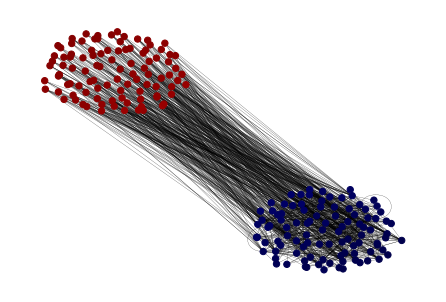

In [ ]:
Ghat = sparsify_graph(G, spectral_CT_dist_G)
posGhat = plot_eigenvector_over_graph(Ghat,evecsG,1, pos = posG)

12913
tensor([19.9289, 20.2349, 20.4008,  ..., 19.8645, 20.1581, 20.2357])
tensor(1.)
957
1000


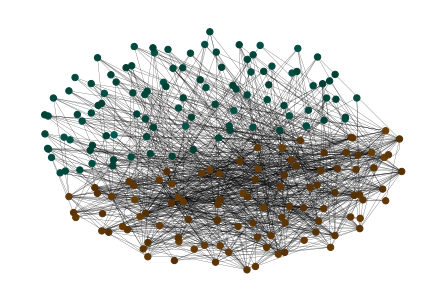

In [ ]:
Hhat = sparsify_graph(H, spectral_CT_dist_H)
posHhat = plot_eigenvector_over_graph(Hhat,evecsG,1, cmap="BrBG", pos = posH)

## Random Walks

In [ ]:
import networkx as nx
import numpy  as np

def get_hitting_path(G, T, start, stop):
  #print("start, stop", start, stop)
  # Visited lists: nodes and edges  
  Visited_nodes = list()
  Visited_edges = list()
  # Current node 
  old_node = start
  Visited_nodes.append(old_node)
  # Get all sorted elements and indices in each step 
  hit = False
  while not hit:
    # Choose the old_node-th row of T which is row-stochastic
    q = T[old_node,:]
    new_node = np.random.choice(G.number_of_nodes(), 1, replace = True, p = q)[0]
    #print(new_node)
    Visited_nodes.append(new_node)
    Visited_edges.append((old_node,new_node))
    if new_node == stop:
      hit = True
    else: 
      old_node = new_node
  hitting_time = len(Visited_nodes) - 1
  return hitting_time, Visited_nodes, Visited_edges

def fast_get_hitting_path(G, T, start, stop):
  #print("start, stop", start, stop)
  # Define starting state
  p = np.zeros(G.number_of_nodes()).reshape(-1,1)
  p[start] = 1
  # Visited lists: nodes and edges  
  Visited_nodes = list()
  Visited_edges = list()
  # Current node 
  old_node = start
  Visited_nodes.append(old_node)
  # Get all sorted elements and indices in each step 
  hit = False
  #k = 0
  while not hit:
    # evaluate the next state vector
    p = np.squeeze(np.dot(T,p))
    #print("p", p)
    # choose the node with higher probability as the visited node
    # Exclude returning to old node
    nzidx = np.squeeze(np.squeeze(np.asarray(np.nonzero(p))))
    #print("nzidz", nzidx)
    q = np.squeeze(p[nzidx])
    #print("q", q)
    q = q/q.sum() # constrained to the non-zero (accessible nodes)
    rel_new_node = np.random.choice(q.size, 1, replace = True, p = q)[0]
    #print(rel_new_node)
    new_node = nzidx[rel_new_node]
    #print(new_node)
    Visited_nodes.append(new_node)
    Visited_edges.append((old_node,new_node))
    if new_node == stop:
      hit = True
    else: 
      old_node = new_node
    #k +=1 
    #if k>10: 
    #  break
  hitting_time = len(Visited_nodes) - 1
  return hitting_time, Visited_nodes, Visited_edges

kth 0
kth 1
kth 2
kth 3
kth 4
kth 5
kth 6
kth 7
kth 8
kth 9
kth 10
kth 11
kth 12
kth 13
kth 14
kth 15
kth 16
kth 17
kth 18
kth 19
kth 20
kth 21
kth 22
kth 23
kth 24
kth 25
kth 26
kth 27
kth 28
kth 29
kth 30
kth 31
kth 32
kth 33
kth 34
kth 35
kth 36
kth 37
kth 38
kth 39
kth 40
kth 41
kth 42
kth 43
kth 44
kth 45
kth 46
kth 47
kth 48
kth 49
kth 50
kth 51
kth 52
kth 53
kth 54
kth 55
kth 56
kth 57
kth 58
kth 59
kth 60
kth 61
kth 62
kth 63
kth 64
kth 65
kth 66
kth 67
kth 68
kth 69
kth 70
kth 71
kth 72
kth 73
kth 74
kth 75
kth 76
kth 77
kth 78
kth 79
kth 80
kth 81
kth 82
kth 83
kth 84
kth 85
kth 86
kth 87
kth 88
kth 89
kth 90
kth 91
kth 92
kth 93
kth 94
kth 95
kth 96
kth 97
kth 98
kth 99
[200, 250, 266, 24, 9, 233, 73, 44, 326, 83, 35, 153, 141, 101, 27, 212, 144, 159, 475, 71, 136, 142, 155, 158, 4, 35, 246, 104, 53, 30, 140, 85, 168, 34, 40, 22, 24, 139, 261, 173, 454, 25, 152, 61, 114, 121, 67, 72, 194, 169, 15, 102, 103, 26, 165, 59, 173, 4, 55, 245, 57, 68, 97, 82, 79, 33, 132, 208, 298,

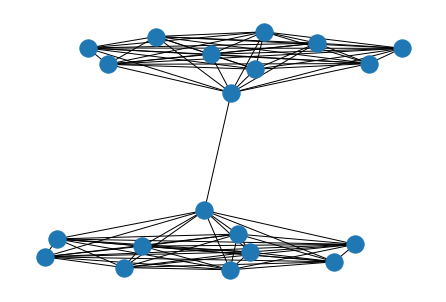

In [ ]:
# Herein is more straight (transition matrix)
import networkx as nx
import numpy  as np

# let's generate a graph G
G = nx.barbell_graph(10, 0)
nx.draw(G)
# let networkx return the adjacency matrix A
#G = H
A = nx.adjacency_matrix(G)
A = A.todense()
A = np.array(A, dtype = np.float64)
# let's evaluate the degree matrix D
D = np.diag(np.sum(A, axis=0))
# ...and the transition matrix T
T = np.dot(np.linalg.inv(D),A)

nsamples = 100
All_visited_nodes_go = list()
All_visited_nodes_back = list()
All_visited_edges_go = list()
All_visited_edges_back = list()
All_hitting_times_go = list()
All_hitting_times_back = list()
for k in range(nsamples):
  hitting_time_go, Visited_nodes_go, Visited_edges_go = get_hitting_path(G, T, 0, 19)
  print("kth", k)
  All_visited_nodes_go.extend(Visited_nodes_go)
  All_visited_edges_go.extend(Visited_edges_go)
  All_hitting_times_go.append(hitting_time_go)
  hitting_time_back, Visited_nodes_back, Visited_edges_back = get_hitting_path(G, T, 19, 0)
  All_visited_nodes_back.extend(Visited_nodes_back)
  All_visited_edges_back.extend(Visited_edges_back)
  All_hitting_times_back.append(hitting_time_back)
print(All_hitting_times_go)
print(All_hitting_times_back)
Huv = np.mean(All_hitting_times_go)
Hvu = np.mean(All_hitting_times_back)
Ruv = (Huv + Hvu)/graph_vol(G)
print("Effective resistance", Ruv)


In [ ]:
# Edge statistics 
# Transforms (u,v) so that (u < v)
All_visited_edges_go_T = list()
for e in All_visited_edges_go: 
  if e[0]>e[1]:
    All_visited_edges_go_T.append((e[1],e[0]))
  else: 
    All_visited_edges_go_T.append((e[0],e[1]))
All_visited_edges_back_T = list()
for e in All_visited_edges_back: 
  if e[0]>e[1]:
    All_visited_edges_back_T.append((e[1],e[0]))
  else: 
    All_visited_edges_back_T.append((e[0],e[1]))

All_visited_edges_T = list()
for e in All_visited_edges_go_T: 
  All_visited_edges_T.append(e)
for e in All_visited_edges_back_T: 
  All_visited_edges_T.append(e)

print("Go ", All_visited_edges_go)
print("   ", All_visited_edges_go_T)
print(len(All_visited_edges_go_T))
print("Bck", All_visited_edges_back)
print("   ", All_visited_edges_back_T)
print(len(All_visited_edges_go_T))
print("All", All_visited_edges_T)
print(len(All_visited_edges_T))
print("Ori", G.edges())
print(len(G.edges()))

edgeHist_go = list()
for e in G.edges():
  edgeHist_go.append(All_visited_edges_go_T.count(e))
print("Hist go ", edgeHist_go)

edgeHist_back = list()
for e in G.edges():
  edgeHist_back.append(All_visited_edges_back_T.count(e))
print("Hist bck", edgeHist_back)

edgeHist_all = list()
for e in G.edges():
  edgeHist_all.append(All_visited_edges_T.count(e))
print("Hist all", edgeHist_all)
print("Hist_lengths: go, back, all:", len(edgeHist_go), len(edgeHist_back), len(edgeHist_all))

Go  [(0, 8), (8, 1), (1, 5), (5, 3), (3, 8), (8, 2), (2, 7), (7, 3), (3, 5), (5, 7), (7, 9), (9, 8), (8, 0), (0, 2), (2, 5), (5, 3), (3, 2), (2, 7), (7, 9), (9, 2), (2, 0), (0, 7), (7, 5), (5, 7), (7, 1), (1, 7), (7, 5), (5, 6), (6, 1), (1, 0), (0, 9), (9, 0), (0, 6), (6, 9), (9, 4), (4, 6), (6, 8), (8, 3), (3, 2), (2, 0), (0, 3), (3, 5), (5, 3), (3, 7), (7, 4), (4, 1), (1, 9), (9, 1), (1, 3), (3, 6), (6, 7), (7, 4), (4, 8), (8, 5), (5, 4), (4, 1), (1, 3), (3, 8), (8, 6), (6, 0), (0, 4), (4, 3), (3, 9), (9, 5), (5, 8), (8, 6), (6, 1), (1, 5), (5, 1), (1, 2), (2, 0), (0, 4), (4, 3), (3, 0), (0, 8), (8, 4), (4, 6), (6, 2), (2, 6), (6, 3), (3, 7), (7, 5), (5, 0), (0, 7), (7, 3), (3, 5), (5, 9), (9, 6), (6, 5), (5, 6), (6, 5), (5, 1), (1, 8), (8, 0), (0, 5), (5, 9), (9, 8), (8, 2), (2, 3), (3, 7), (7, 5), (5, 2), (2, 7), (7, 2), (2, 4), (4, 8), (8, 1), (1, 9), (9, 7), (7, 3), (3, 6), (6, 5), (5, 0), (0, 4), (4, 1), (1, 6), (6, 9), (9, 4), (4, 7), (7, 6), (6, 2), (2, 4), (4, 3), (3, 0), (0,

In [ ]:
# Plot the intensity of edge visiting on the Graph and the start and stop node
def plot_edge_intensity_over_graph(G,start, stop, edge_Hist):
  # Info to plot in G.edges()
  # Info to plot in G.nodes()
  u = edge_Hist
  n = 0.25*np.ones(G.number_of_nodes())
  n[start] = 1
  n[stop] = -1
   
  # Create the color maps 
  eColor =mcp.gen_color_normalized(cmap="seismic",data_arr=u)
  nColor =mcp.gen_color_normalized(cmap="seismic",data_arr=n)
  #pos = nx.spring_layout(G,seed=63)
  pos = nx.spring_layout(G)
  options = {
    "node_color": nColor, #"#A0CBE2",
    "edge_color": eColor,
    "width": 2,
    "edge_cmap": plt.cm.Blues,
    "with_labels": False,
  }
  # Draw the graph
  nx.draw(G, pos, **options)
  plt.show()

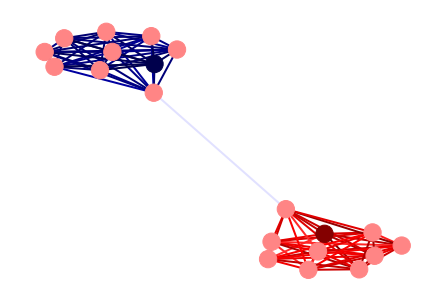

In [ ]:
plot_edge_intensity_over_graph(G,start=0, stop=19, edge_Hist=edgeHist_go)

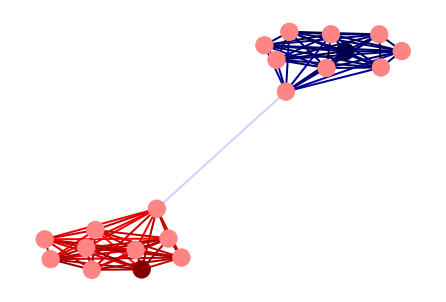

In [ ]:
plot_edge_intensity_over_graph(G,start=19, stop=0, edge_Hist=edgeHist_back)

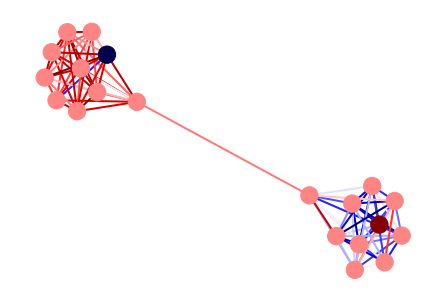

In [ ]:
plot_edge_intensity_over_graph(G,start=0, stop=19, edge_Hist=edgeHist_all)

In [ ]:
# Using seaborn
import pandas as pd

df_Edges_G = pd.DataFrame(list(zip(DiscG,['G']*len(DiscG))), columns=['Disc', 'Graph'])
df_Disc_H = pd.DataFrame(list(zip(DiscH,['H']*len(DiscH))), columns=['Disc', 'Graph'])
df_Disc = pd.concat([df_Disc_G, df_Disc_H]).reset_index()

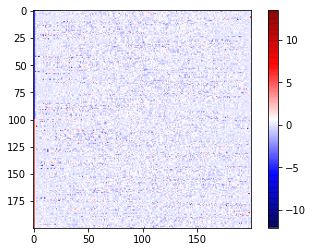

In [ ]:
# Transpose of commute times and scaled eigenvectors
Theta_G = spectral_CTE_G
plt.imshow(Theta_G, alpha=0.8, cmap="seismic")
plt.colorbar()


(200, 200)


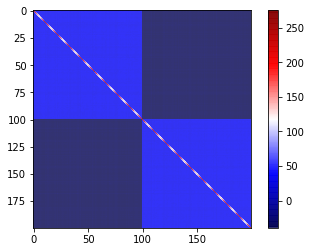

In [ ]:
# K = vol*Theta^T*Theta 
K = np.matmul(Theta_G,Theta_G.T)
print(K.shape)
plt.imshow(K, alpha=0.8, cmap="seismic")
plt.colorbar()

(200, 200)
[267.62726777 226.76802357 233.91008385 234.75523952 236.50463269
 238.33461336 203.22952654 224.62441073 219.41161407 226.13565925
 246.38469747 237.33093642 231.45307597 228.2632128  254.26929637
 244.51470366 229.15354648 238.15282924 249.18109828 233.92177396
 234.8164088  235.53600715 248.34979532 258.05168452 220.03169149
 241.01155763 253.07081208 220.5396661  223.82462    234.14213733
 222.29442497 227.53662134 238.30056462 229.89830049 223.58495127
 241.77319555 222.19430595 232.26532765 226.81342074 236.53399595
 219.0742053  235.58300419 262.46608849 240.86957786 235.70644536
 241.82923939 222.30644272 238.96188104 248.99085789 225.12249486
 243.60115313 239.16095804 244.4860528  223.83943772 225.96154305
 239.18477399 274.83278374 220.61800516 253.24652234 230.84399556
 230.9001684  223.8227775  239.16297558 248.28960189 229.09729773
 222.2210596  239.90785434 227.44827314 230.76510738 226.14520228
 223.66234603 226.76551045 214.28416968 233.12291173 229.05291101

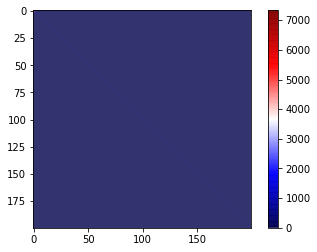

In [ ]:
#Scaled inverse eigenvalues of the Laplacian (Eigenvalues of Green's function)
# Cf = vol*Theta^T*Theta = (1/Lambda) 
Cf = np.matmul(Theta_G.T,Theta_G)
print(K.shape)
plt.imshow(Cf, alpha=0.8, cmap="seismic")
plt.colorbar()
# Obviously the max value is given at Fiedler's position
print(np.diag(K))

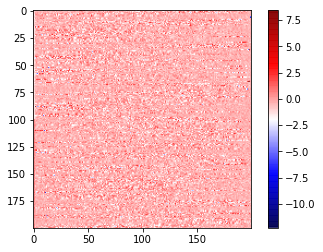

In [ ]:
# Transpose of commute times and scaled eigenvectors
Theta_H = spectral_CTE_H
plt.imshow(Theta_H, alpha=0.8, cmap="seismic")
plt.colorbar()

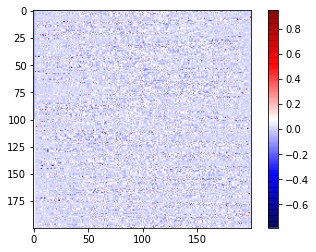

In [ ]:
plt.imshow(evecsG, alpha=0.8, cmap="seismic")
plt.colorbar()

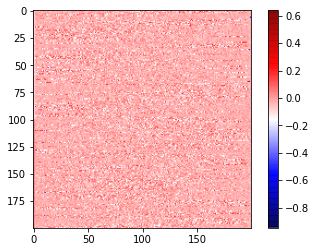

In [ ]:
plt.imshow(evecsH, alpha=0.8, cmap="seismic")
plt.colorbar()

Min diff is 5.171444013712261e-05
Max diff is 12.624307256540096
Avg 0.665855348869955 +- std 0.7662067523616065


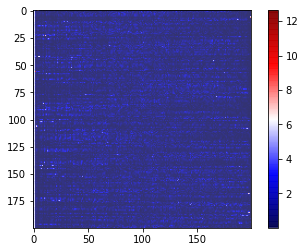

In [ ]:
DiscG= np.asarray(abs(evecsG-Theta_G)).flatten()
plt.imshow(abs(evecsG-Theta_G), alpha=0.8, cmap="seismic")
plt.colorbar()
print("Min diff is", np.min(DiscG))
print("Max diff is", np.max(DiscG))
meanDiscG = np.mean(DiscG)
stdDiscG = np.std(DiscG)
print(f"Avg {meanDiscG} +- std {stdDiscG}")

Min diff is 3.8153602235135766e-06
Max diff is 11.345564348640574
Avg 0.6648129525150843 +- std 0.6463866040047862


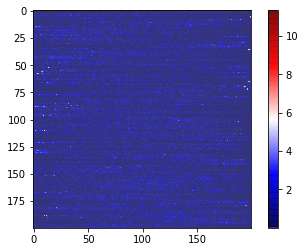

In [ ]:
DiscH= np.asarray(abs(evecsH-Theta_H)).flatten()
plt.imshow(abs(evecsH-Theta_H), alpha=0.8, cmap="seismic")
plt.colorbar()
print("Min diff is", np.min(DiscH))
print("Max diff is", np.max(DiscH))
meanDiscH = np.mean(DiscH)
stdDiscH = np.std(DiscH)
print(f"Avg {meanDiscH} +- std {stdDiscH}")

In [ ]:
# Using seaborn
import pandas as pd

df_Disc_G = pd.DataFrame(list(zip(DiscG,['G']*len(DiscG))), columns=['Disc', 'Graph'])
df_Disc_H = pd.DataFrame(list(zip(DiscH,['H']*len(DiscH))), columns=['Disc', 'Graph'])
df_Disc = pd.concat([df_Disc_G, df_Disc_H]).reset_index()

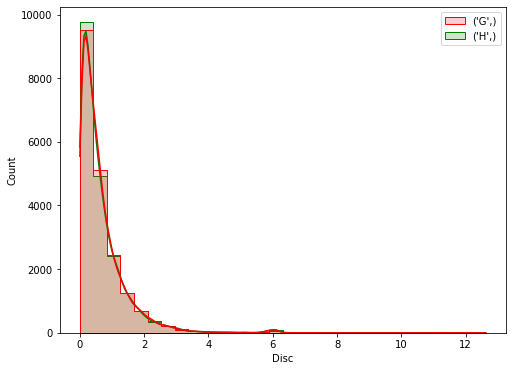

In [ ]:
style = {'bins':30, 'kde':True, 'element':"step"}
plt.figure(figsize=(8,6))
sns.histplot(data=df_Disc, x='Disc', hue=df_prob[['Graph']].apply(tuple, axis=1), alpha=0.2, palette=["r", "g"], **style)
plt.show()